# Evaluation (Local)

In [ ]:
!pip install statsmodels==0.12.2

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from tqdm.notebook import tqdm, trange
import copy
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import sys
from sklearn.linear_model import LinearRegression
import random
from datetime import datetime
from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings("ignore")

root_dir = 'drive/MyDrive/EconML DL/'

## Step 1: Load Data

In [4]:
# Loading the Data - 7 Variables

data = pd.read_csv('../../data/monthlyData.csv')
data = data.rename(columns = {'Unnamed: 0': 'Date'})
data = data.set_index('Date')
x_d = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d['L0_HOUST'] = x_d['L0_HOUST'].diff()
x_d = x_d.dropna()
x_d.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']

# Subset the variables we want
x_d = x_d[['inf', 'unrate', 'DGS3']]
x_d_colnames = x_d.columns
n_vars = len(x_d.columns)
var_names = list(x_d_colnames)

In [6]:
# 7-variables quarterly
data = pd.read_csv('../../data/monthlyData.csv')
data['quarter'] = ((data['trend'] ) / 3).astype(int)
data = data.groupby('quarter').mean().reset_index()
data['L0_HOUST'] = data['L0_HOUST'].diff()
data = data.dropna()
x_d = data[['L0_OILPRICEx', 'L0_EXUSUKx', 'L0_S.P.500', 'L0_TB3MS', 'L_0y', 'L0_UNRATE', 'L0_HOUST']]
x_d.columns = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']
x_d_colnames = x_d.columns
n_vars = len(x_d.columns)
var_names = list(x_d_colnames)

In [8]:
# Monthly Data
data = pd.read_csv('../../data/ryan_data_h1.csv')
data = data.dropna()
x_d = data[['Y_sp', 'Y_nas', 'Y_vix', 'Y_dj']]
x_d.columns = ['S&P', 'NASDAQ', 'VIX', 'DJIA']
x_d_colnames = x_d.columns
n_var = len(x_d.columns)
var_names = list(x_d_colnames)

In [9]:
data = pd.read_csv('../../data/VARCTIC8.csv')
data = data.dropna()
x_d_all = data[['CO2_MaunaLoa', 'TCC', 'PR', 'AT', 'SST', 'SIE', 'SIT', 'Albedo']]
x_d_all.columns = ['CO2_MaunaLoa', 'TCC', 'PR', 'AT', 'SST', 'SIE', 'SIT', 'Albedo']
x_d_all_colnames = x_d_all.columns
n_var = len(x_d_all.columns)
var_names = list(x_d_all_colnames)

## Step 2: Specifying Experiment Names

In [10]:
results_root_dir = '../../../Compute Canada'

In [73]:
# All the manual entries to fill up before running the results

experiment_name = '7jul_multi_forecasting_quarterly'
n_vars = 3
n_lag_linear = 2
M_varnn = 4 # Number of VARNN models

need_to_combine = True
is_simulation = False
multiple_datasets = False
sim_dataset = 2
savefile_header = f''

M_benchmarks = 0
benchmarks = ['VAR_expand', 'AR_expand', 'VAR_roll', 'AR_roll', 'VAR_whole', 'AR_whole', 'RF_whole']
benchmarks = benchmarks[:M_benchmarks]
num_bootstraps = 200
test_size = 40

#var_names = ['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'house_starts']
#var_names = ['Interest', 'Inf', 'Unemp']
var_names = ['inf', 'unrate', 'DGS3']
#var_names = ['S&P', 'NASDAQ', 'VIX', 'DJIA']
#var_names = ['CO2_MaunaLoa', 'TCC', 'PR', 'AT', 'SST', 'SIE', 'SIT', 'Albedo']

In [44]:
# Create benchmark folder if not exist yet

folder_path = f'{results_root_dir}/{experiment_name}'

benchmark_folder_path = f'{folder_path}/benchmarks'
if os.path.isdir(benchmark_folder_path) == False:
  os.mkdir(benchmark_folder_path)

# Create image folder if not exist yet
image_folder_path = f'{folder_path}/images'
if os.path.isdir(image_folder_path) == False:
  os.mkdir(image_folder_path)

# If there are different datasets then create folder for each
if multiple_datasets == True:
  image_folder_path = f'{image_folder_path}/dataset_{sim_dataset}'
  if os.path.isdir(image_folder_path) == False:
    os.mkdir(image_folder_path)

In [53]:
# @title Code to Combine Results from Multiple Repeats (for Compute Canada - where the results might not start with 0)

# dictionary of keys to keep and the dimension of bootstrap
keys_to_keep = {'betas': 2,
                'betas_in': 2,
                'sigmas': 3,
                'sigmas_in': 3, 
                'precision': 3,
                'precision_in': 3,
                'cholesky': 3, 
                'cholesky_in': 3, 
                'train_preds': 1, 
                'test_preds': 1}

if need_to_combine == True:
  for experiment in range(M_varnn):
    
    # Check all file names that matches a certain starting string
    file_names = []
    for file in os.listdir(folder_path):
        if file.startswith(f'params_{experiment}_repeat'):
            file_names.append(file)
    
    print(file_names)
    
    # Load the first result
    for i, file_name in enumerate(file_names):
        if i == 0:
            out = np.load(f'{folder_path}/{file_name}', allow_pickle = True)
            out_all = {k:v for k,v in out.items() if k in keys_to_keep.keys()}
        else:
            for k, v in out_all.items():
                out_all[k] = np.concatenate([out_all[k], out[k]], axis = keys_to_keep[k])                
        
    out_all['params'] = out['params']
    out_all['y'] = out['y']
    out_all['y_test'] = out['y_test']

    with open(f'{folder_path}/{savefile_header}params_{experiment}_compiled.npz', 'wb') as f:
        np.savez(f, **out_all)

['params_0_repeat_1.npz', 'params_0_repeat_10.npz', 'params_0_repeat_2.npz', 'params_0_repeat_3.npz', 'params_0_repeat_4.npz', 'params_0_repeat_5.npz', 'params_0_repeat_6.npz', 'params_0_repeat_7.npz', 'params_0_repeat_8.npz', 'params_0_repeat_9.npz']
['params_1_repeat_1.npz', 'params_1_repeat_10.npz', 'params_1_repeat_2.npz', 'params_1_repeat_3.npz', 'params_1_repeat_4.npz', 'params_1_repeat_5.npz', 'params_1_repeat_6.npz', 'params_1_repeat_7.npz', 'params_1_repeat_8.npz', 'params_1_repeat_9.npz']
['params_2_repeat_1.npz', 'params_2_repeat_10.npz', 'params_2_repeat_2.npz', 'params_2_repeat_3.npz', 'params_2_repeat_4.npz', 'params_2_repeat_5.npz', 'params_2_repeat_6.npz', 'params_2_repeat_7.npz', 'params_2_repeat_8.npz', 'params_2_repeat_9.npz']
['params_3_repeat_1.npz', 'params_3_repeat_10.npz', 'params_3_repeat_2.npz', 'params_3_repeat_3.npz', 'params_3_repeat_4.npz', 'params_3_repeat_5.npz', 'params_3_repeat_6.npz', 'params_3_repeat_7.npz', 'params_3_repeat_8.npz', 'params_3_repeat_

## Time-Varying Cov Mat and Coefs

### Estimating Linear VAR using the data

In [ ]:
# Estimate the VAR
var_model_estimated = VAR(x_d)
var_fit = var_model_estimated.fit(4)
var_resid = var_fit.resid
# Get standardized residuals
var_resid_std = var_resid / x_d.std()
var_resid_std_cov_mat = var_resid_std.cov()
# Get the standardized precision matrix
var_resid_std_precision_mat = np.linalg.inv(var_resid_std_cov_mat)

In [ ]:
var_resid_std_precision_mat

### Loading Results

In [ ]:
# @title Old simulations

# # Load the actual simgas and betas
# sim_data = np.load(f'simulation_data_joint.npz', allow_pickle = True)
# cov_mat_tv_all = sim_data['cov_mat_tv_all'] 
# coefs_tv_all = sim_data['coefs_tv_all']
# exog = sim_data['exog']

# # Subset for the dataset (and also remove first 8 values due to lag)
# cov_mat_tv = cov_mat_tv_all[8:, :, :, sim_dataset]
# coefs_tv = coefs_tv_all[8:, :, :, sim_dataset]


### New simulations
#sim_data = np.load(f'simulation_data_joint_19jun.npz', allow_pickle = True)
# sim_data = np.load(f'simulation_data_joint_20jun.npz', allow_pickle = True)
# cov_mat_tv = sim_data['cov_mat_tv'] 
# coefs_tv = sim_data['coefs_tv_all']
# exog = sim_data['exog']

# cov_mat_tv = np.transpose(cov_mat_tv[:,:,8:], (2,0,1))
# coefs_tv = np.transpose(coefs_tv[:,:,8:], (2,0,1))

# sim_data = np.load(f'imulation_data_joint_21jun.npz', allow_pickle = True)
# cov_mat_tv_all = sim_data['cov_mat_tv_all'] 
# coefs_tv_all = sim_data['coefs_tv_all']
# exog_all = sim_data['exog_all']

# cov_mat_tv = cov_mat_tv_all[8:, :, :, sim_dataset]
# coefs_tv = coefs_tv_all[8:, :, :, sim_dataset]
# exog = exog_all[8:, :, sim_dataset]

In [ ]:
sim_data = np.load(f'Simulation Data/july_simulated_data_group1.npz', allow_pickle = True)
cov_mat_tv_all = sim_data['cov_mat_tv_all'] 
coefs_tv_all = sim_data['coefs_tv_all']
exog_all = sim_data['exog_all']

cov_mat_tv = cov_mat_tv_all[8:,:,:, sim_dataset]
coefs_tv = coefs_tv_all[8:,:,:, sim_dataset]
exog = exog_all[:,:,sim_dataset]

In [ ]:
n_var = 3
# Plot betas
fig, axs = plt.subplots(n_var, n_var, figsize = (4 * n_var, 3 * n_var), constrained_layout = True)
for i in range(n_var):
  for j in range(n_var):
    axs[i,j].plot(coefs_tv[:,i,j])

n_var = 3
# Plot betas
fig, axs = plt.subplots(n_var, n_var, figsize = (4 * n_var, 3 * n_var), constrained_layout = True)
for i in range(n_var):
  for j in range(n_var):
    axs[i,j].plot(cov_mat_tv[:,i,j])

In [74]:
# @title Load Sigmas

# Load Betas both from Experiment and Benchmarks

experiments_to_load = list(range(M_varnn))
experiments_names = []

M_betas = len(experiments_to_load)
M_benchmarks = 0
M_total = M_betas + M_benchmarks
M_with_hemi = []

# Load all the betas from different experiments
for i in range(len(experiments_to_load)):
  experiment = experiments_to_load[i]
  
  compiled_text = 'compiled' if need_to_combine == True else 'repeat_1'
  dataset_text = f'_dataset_{sim_dataset}' if multiple_datasets == True else ''
  load_file = f'{folder_path}/{savefile_header}params_{experiment}{dataset_text}_{compiled_text}.npz'

  out = np.load(load_file, allow_pickle = True)

  experiments_names.append(out['params'].item()['name'])

  SIGMAS = out['sigmas']
  SIGMAS_IN = out['sigmas_in']
  PRECISION = out['precision']
  PRECISION_IN = out['precision_in']
  CHOLESKY = out['cholesky']
  CHOLESKY_IN = out['cholesky_in']
  print('SIGMAS', SIGMAS.shape)
  print('CHOLESKY', CHOLESKY.shape)

  # Estimate time-invariant cov mat from the residuals
  Y_train = out['y']
  PREDS = out['train_preds']
  resids = np.repeat(np.expand_dims(Y_train, axis = 1), PREDS.shape[1], axis = 1) - PREDS

  if i == 0:
    # n_models x n_obs x n_vars x n_vars x n_bootstraps
    SIGMAS_ALL = np.zeros((M_total, SIGMAS.shape[0], SIGMAS.shape[1], SIGMAS.shape[2], num_bootstraps))
    SIGMAS_ALL[:] = np.nan
    PRECISION_ALL = np.zeros_like(SIGMAS_ALL)
    PRECISION_ALL[:] = np.nan
    CHOLESKY_ALL = np.zeros((M_total, SIGMAS.shape[0], SIGMAS.shape[1], SIGMAS.shape[2], 2, num_bootstraps))
    CHOLESKY_ALL[:] = np.nan 

    SIGMAS_IN_ALL = np.zeros((M_total, SIGMAS_IN.shape[0], SIGMAS_IN.shape[1], SIGMAS_IN.shape[2], num_bootstraps))
    SIGMAS_IN_ALL[:] = np.nan 
    PRECISION_IN_ALL = np.zeros_like(SIGMAS_IN_ALL)
    PRECISION_IN_ALL[:] = np.nan
    CHOLESKY_IN_ALL = np.zeros_like(CHOLESKY_ALL)
    CHOLESKY_IN_ALL[:] = np.nan

    SIGMAS_CONS_ALL = np.zeros((M_total, SIGMAS.shape[1], SIGMAS.shape[2], num_bootstraps))
    SIGMAS_CONS_ALL[:] = np.nan

    SIGMAS_ALL[i, :,:,:,:] = SIGMAS
    SIGMAS_IN_ALL[i, :,:,:,:] = SIGMAS_IN
    PRECISION_ALL[i, :,:,:,:] = PRECISION
    PRECISION_IN_ALL[i, :,:,:,:] = PRECISION_IN
#     CHOLESKY_ALL[i, :,:,:,:, :] = CHOLESKY
#     CHOLESKY_IN_ALL[i, :,:,:,:, :] = CHOLESKY_IN

    for b in range(num_bootstraps):
      SIGMAS_CONS_ALL[i, :,:,b] = pd.DataFrame(resids[:, b, :]).dropna().cov()

  else:
    SIGMAS_ALL[i, :,:,:,:] = SIGMAS
    SIGMAS_IN_ALL[i, :,:,:,:] = SIGMAS_IN
    PRECISION_ALL[i, :,:,:,:] = PRECISION
    PRECISION_IN_ALL[i, :,:,:,:] = PRECISION_IN
#     CHOLESKY_ALL[i, :,:,:,:,:] = CHOLESKY
#     CHOLESKY_IN_ALL[i, :,:,:,:,:] = CHOLESKY_IN
    
    for b in range(num_bootstraps):
      SIGMAS_CONS_ALL[i, :,:,b] = pd.DataFrame(resids[:, b, :]).dropna().cov()

SIGMAS (230, 3, 3, 200)
CHOLESKY (230, 3, 3, 200)
SIGMAS (230, 3, 3, 200)
CHOLESKY (230, 3, 3, 200)
SIGMAS (230, 3, 3, 200)
CHOLESKY (230, 3, 3, 200)
SIGMAS (230, 3, 3, 200)
CHOLESKY (230, 3, 3, 200)


In [75]:
# @title Load Betas from One Number of Variables

# Load Betas both from Experiment and Benchmarks

experiments_to_load = list(range(M_varnn))
experiments_names = []

M_betas = len(experiments_to_load)
M_benchmarks = 0
M_total = M_betas + M_benchmarks
M_with_hemi = []

# Load all the betas from different experiments
for i in range(len(experiments_to_load)):
  experiment = experiments_to_load[i]

  compiled_text = 'compiled' if need_to_combine == True else 'repeat_1'
  dataset_text = f'_dataset_{sim_dataset}' if multiple_datasets == True else ''
  load_file = f'{folder_path}/{savefile_header}params_{experiment}{dataset_text}_{compiled_text}.npz'

  out = np.load(load_file, allow_pickle = True)
  
  experiments_names.append(out['params'].item()['name'])
  BETAS = out['betas']
  BETAS_IN = out['betas_in']
  print('BETAS_IN', BETAS_IN.shape)

  # if i == 18:
  #   n_lag_linear = 2
  # For experiments with more than 1 lag, get the ids of the 1st beta to plot
  beta_ids_to_keep = [0] + list(range(1, BETAS_IN.shape[1], n_lag_linear))
  print(beta_ids_to_keep)
  BETAS_IN = BETAS_IN[:, beta_ids_to_keep, :,:,:]
  BETAS = BETAS[:, beta_ids_to_keep, :,:,:]

  # Record the models that have >1 hemispheres
  if BETAS.shape[4] > 1:
    M_with_hemi.append(i)


  if i == 0:
    #BETAS_ALL = np.zeros((M_total, BETAS.shape[0], BETAS.shape[1], num_bootstraps, BETAS.shape[3], 2))
    BETAS_ALL = np.zeros((M_total, BETAS.shape[0], BETAS.shape[1], num_bootstraps, BETAS.shape[3], BETAS.shape[4]))
    BETAS_ALL[:] = np.nan
    # n_models x n_obs x n_betas x n_bootstraps x n_vars x n_hemispheres
    
    #BETAS_IN_ALL = np.zeros((M_total, BETAS_IN.shape[0], BETAS_IN.shape[1], num_bootstraps, BETAS_IN.shape[3], 2))
    BETAS_IN_ALL = np.zeros((M_total, BETAS_IN.shape[0], BETAS_IN.shape[1], num_bootstraps, BETAS_IN.shape[3], BETAS_IN.shape[4]))
    BETAS_IN_ALL[:] = np.nan 

  # If >1 hemis, Demean the time hemisphere and add the mean to the endogenous hemisphere
  # (note: the means are the in-sample means, not the oob ones)
  if BETAS.shape[4] > 1:
    time_hemi_means = np.nanmean(BETAS_IN[:,:,:,:,1], axis = 0)
    time_hemi_means_expand = np.repeat(np.expand_dims(time_hemi_means, axis = 0), BETAS.shape[0], axis = 0)
    # BETAS_IN[:, :, :, :, 0] = BETAS_IN[:, :, :, :, 0] + time_hemi_means_expand
    # BETAS_IN[:, :, :, :, 1] = BETAS_IN[:, :, :, :, 1] - time_hemi_means_expand
    # BETAS[:, :, :, :, 0] = BETAS[:, :, :, :, 0] + time_hemi_means_expand
    # BETAS[:, :, :, :, 1] = BETAS[:, :, :, :, 1] - time_hemi_means_expand

  BETAS_ALL[i,:,:,:BETAS_IN.shape[2],:, :BETAS_IN.shape[4]] = BETAS
  BETAS_IN_ALL[i,:,:,:BETAS_IN.shape[2],:, :BETAS_IN.shape[4]] = BETAS_IN

BETAS_IN (230, 7, 200, 3, 2)
[0, 1, 3, 5]
BETAS_IN (230, 7, 200, 3, 2)
[0, 1, 3, 5]
BETAS_IN (230, 7, 200, 3, 2)
[0, 1, 3, 5]
BETAS_IN (230, 7, 200, 3, 2)
[0, 1, 3, 5]


In [76]:
# @title Eliminate Bootstraps that don't move

# Eliminate the sigmas, precision and betas that do not change much - defined as bootstrap runs with <10% the SD of the median for any of the estimated cov mat params

bootstraps_to_delete = []

for i in range(M_varnn):
  low_sd_ids = []
  # SD of sigmas across all bootstraps
  sigmas_sd = np.nanstd(SIGMAS_IN_ALL[i, :, :, :, :], axis = 0)
  for row in range(n_vars):
    for col in range(n_vars):
      sigmas_sd_alpha = sigmas_sd[row, col, :]
      # Standardize by median
      sigmas_sd_alpha = sigmas_sd_alpha / np.median(sigmas_sd_alpha)
      # Get indexes where the SD is <10% of the median
      low_sd_id = np.where(sigmas_sd_alpha < 0.1)[0]
      low_sd_ids.append(list(low_sd_id))

  # Get the union of all the low-sd ids
  print(low_sd_ids)
  low_sd_ids = set().union(*low_sd_ids)
  low_sd_ids = list(low_sd_ids)

  bootstraps_to_delete.append(low_sd_ids.copy())

  print(f'Experiment {i}, Low-SD ids: {len(low_sd_ids)}')

  if len(low_sd_ids) > 0:
    # Set the low-sd ids to np.nan (i.e. remove them)
    SIGMAS_IN_ALL[i, :, :, :, low_sd_ids] = np.nan
    SIGMAS_ALL[i, :, :, :, low_sd_ids] = np.nan
    SIGMAS_CONS_ALL[i, :, :, low_sd_ids] = np.nan
    PRECISION_IN_ALL[i, :, :, :, low_sd_ids] = np.nan
    PRECISION_ALL[i, :, :, :, low_sd_ids] = np.nan

    BETAS_IN_ALL[i, :, :, low_sd_ids, :, :] = np.nan
    BETAS_ALL[i, :, :, low_sd_ids, :, :] = np.nan

[[], [], [], [], [], [], [], [], [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]]
Experiment 0, Low-SD ids: 10
[[], [], [], [], [], [], [], [], []]
Experiment 1, Low-SD ids: 0
[[], [8, 28, 48, 68, 88, 108, 128, 148, 168, 188], [], [8, 28, 48, 68, 88, 108, 128, 148, 168, 188], [], [14, 18, 34, 38, 54, 58, 74, 78, 94, 98, 114, 118, 134, 138, 154, 158, 174, 178, 194, 198], [], [14, 18, 34, 38, 54, 58, 74, 78, 94, 98, 114, 118, 134, 138, 154, 158, 174, 178, 194, 198], []]
Experiment 2, Low-SD ids: 30
[[2, 22, 42, 62, 82, 102, 122, 142, 162, 182], [], [], [], [5, 11, 25, 31, 45, 51, 65, 71, 85, 91, 105, 111, 125, 131, 145, 151, 165, 171, 185, 191], [5, 25, 45, 65, 85, 105, 125, 145, 165, 185], [], [5, 25, 45, 65, 85, 105, 125, 145, 165, 185], [5, 25, 45, 65, 85, 105, 125, 145, 165, 185]]
Experiment 3, Low-SD ids: 30


In [77]:
# Settings to configure

is_test = False
plot_all_bootstraps = True
is_test_text = '_test' if is_test == True else ''
exps_to_plot = [0]
#exps_to_plot = range(M_varnn)

**Plotting Cholesky of the Precision Matrix**

In [ ]:
# Plot Cholesky Matrix

# Don't show test (change this code to show in-sample)
if is_test == False:
  CHOLESKY_ALL_PLOT = CHOLESKY_ALL[:, :-test_size,:,:,:,:]
  #CHOLESKY_ALL_PLOT = CHOLESKY_ALL[:, 9000:10000,:,:,:,:]
else:
  CHOLESKY_ALL_PLOT = CHOLESKY_ALL[:, -test_size:,:,:,:,:]

for i in exps_to_plot:
  fig, axs = plt.subplots(n_vars, n_vars, figsize = (6 * n_vars, 4 * n_vars), constrained_layout = True)

  for row in range(n_vars):
    for col in range(n_vars):
      for hemi in range(CHOLESKY_ALL_PLOT.shape[-2]):
        
        # Plot every bootstrap's value
        # if plot_all_bootstraps == True:
        #   for b in range(CHOLESKY_ALL_PLOT.shape[4]):
        #     axs[row, col].plot(CHOLESKY_ALL_PLOT[i, :, row, col, b], lw = 0.5, alpha = 0.15, label = i)

        axs[row, col].plot(np.nanmedian(CHOLESKY_ALL_PLOT[i, :, row, col, hemi, :], axis = -1), label = f'Hemi {hemi}')
        axs[row, col].set_title(f'{var_names[row]}, {var_names[col]}')
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('Coefficient')

        sigmas_lcl = np.nanquantile(CHOLESKY_ALL_PLOT[i, :, row, col, hemi, :], axis = -1, q = 0.16)
        sigmas_ucl = np.nanquantile(CHOLESKY_ALL_PLOT[i, :, row, col, hemi, :], axis = -1, q = 0.84)
        axs[row, col].fill_between(list(range(CHOLESKY_ALL_PLOT.shape[1])), sigmas_lcl, sigmas_ucl, alpha = 0.5)

        # Set the y-axis limits to be at the min 10% LCL and max 10% UCL
        # axs[row, col].set_ylim(
        #     np.nanmin(np.nanquantile(CHOLESKY_ALL_PLOT[i, :, row, col, :, 0], axis = -1, q = 0.1)),
        #     np.nanmax(np.nanquantile(CHOLESKY_ALL_PLOT[i, :, row, col, :, 0], axis = -1, q = 0.9))
        # )
        if row == 0 and col == 0:
          axs[row,col].legend()
  fig.suptitle(f'Experiment {i} Cholesky', fontsize=16)
  image_file = f'{image_folder_path}/{savefile_header}_cholesky_{i}{is_test_text}.png'
  plt.savefig(image_file)

PRECISION_ALL_PLOT**Plotting Precision Matrix**

In [80]:
PRECISION_ALL_PLOT.shape

(4, 190, 3, 3, 200)

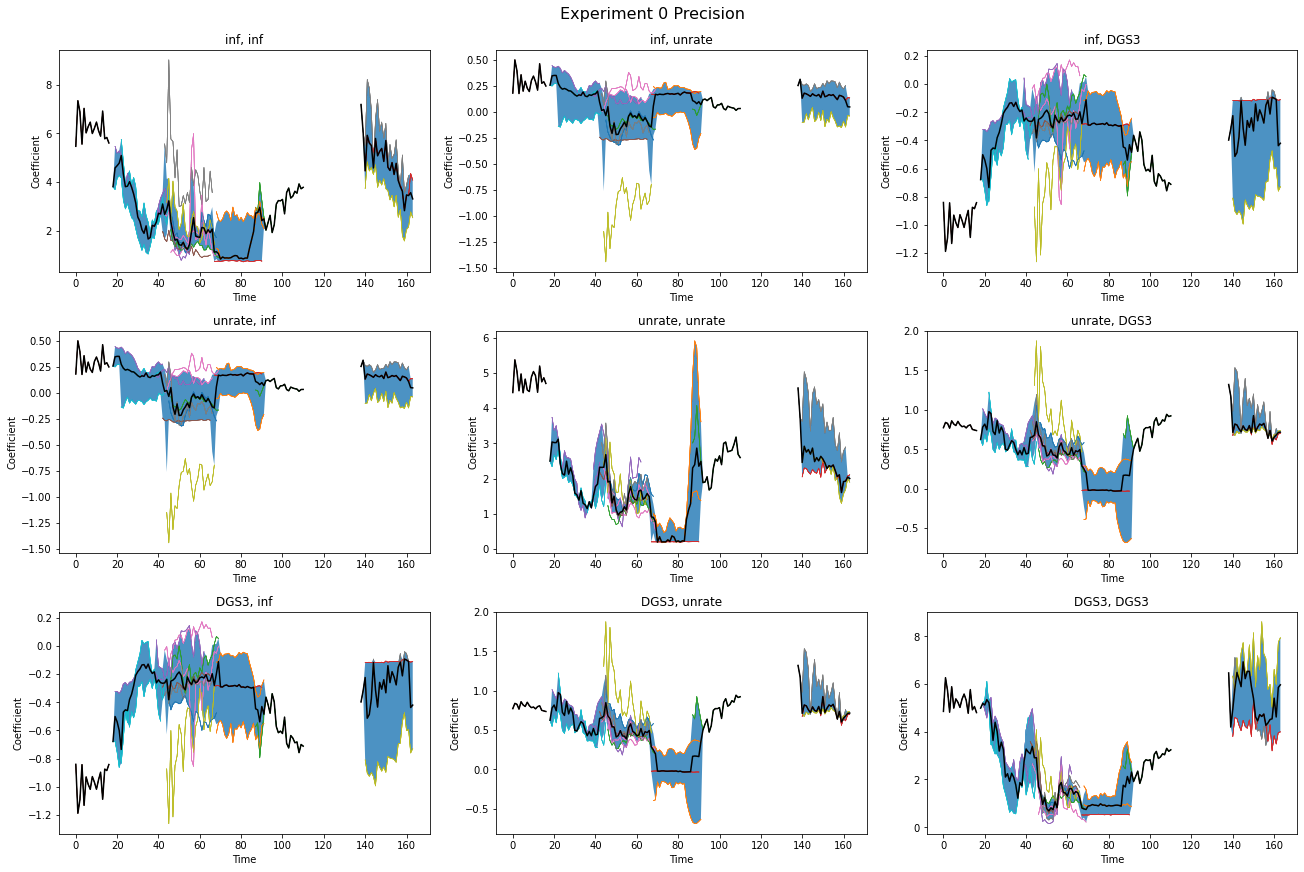

In [86]:
# Plot Precision Matrix

# Don't show test (change this code to show in-sample)
if is_test == False:
  PRECISION_ALL_PLOT = PRECISION_ALL[:, :-test_size,:,:,:]
  #PRECISION_ALL_PLOT = PRECISION_ALL[:, 9000:10000,:,:,:]
else:
  PRECISION_ALL_PLOT = PRECISION_ALL[:, -test_size:,:,:,:]

for i in exps_to_plot:
  fig, axs = plt.subplots(n_vars, n_vars, figsize = (6 * n_vars, 4 * n_vars), constrained_layout = True)

  for row in range(n_vars):
    for col in range(n_vars):
      
      # Plot every bootstrap's value
      if plot_all_bootstraps == True:
        for b in range(PRECISION_ALL_PLOT.shape[4]):
          axs[row, col].plot(PRECISION_ALL_PLOT[i, :, row, col, b], lw = 0.5, alpha = 0.5, label = i)

      axs[row, col].plot(np.nanmedian(PRECISION_ALL_PLOT[i, :, row, col, :], axis = -1), color = 'black')
      axs[row, col].set_title(f'{var_names[row]}, {var_names[col]}')
      axs[row, col].set_xlabel('Time')
      axs[row, col].set_ylabel('Coefficient')

      sigmas_lcl = np.nanquantile(PRECISION_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.16)
      sigmas_ucl = np.nanquantile(PRECISION_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.84)
      axs[row, col].fill_between(list(range(PRECISION_ALL_PLOT.shape[1])), sigmas_lcl, sigmas_ucl, alpha = 0.8)

      # Set the y-axis limits to be at the min 10% LCL and max 10% UCL
      # axs[row, col].set_ylim(
      #     np.nanmin(np.nanquantile(PRECISION_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.1)),
      #     np.nanmax(np.nanquantile(PRECISION_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.9))
      # )
  fig.suptitle(f'Experiment {i} Precision', fontsize=16)
  image_file = f'{image_folder_path}/{savefile_header}_precision_{i}{is_test_text}.png'
  plt.savefig(image_file, facecolor='w', transparent=False)

In [ ]:
# Plot Precision Matrix (FOR THE PRECISION-SPECIFIED SIMULATION)

# Don't show test (change this code to show in-sample)
if is_test == False:
  SIGMAS_ALL_PLOT = PRECISION_ALL[:, :-test_size,:,:,:]
  cov_mat_tv_plot = cov_mat_tv[:-test_size, :, :] if is_simulation == True else None

  #SIGMAS_ALL_PLOT = SIGMAS_ALL[:, 9000:10000,:,:,:]
  #cov_mat_tv_plot = cov_mat_tv[9000:10000, :, :] if is_simulation == True else None
else:
  SIGMAS_ALL_PLOT = SIGMAS_ALL[:, -test_size:,:,:,:]
  cov_mat_tv_plot = cov_mat_tv[-test_size:, :, :] if is_simulation == True else None

for i in exps_to_plot:
  fig, axs = plt.subplots(n_vars, n_vars, figsize = (6 * n_vars, 4 * n_vars), constrained_layout = True)

  for row in range(n_vars):
    for col in range(n_vars):
      
      # Plot every bootstrap's value 
      if plot_all_bootstraps == True:
        for b in range(SIGMAS_IN_ALL.shape[4]):
          axs[row, col].plot(SIGMAS_ALL_PLOT[i, :, row, col, b], lw = 0.5, alpha = 0.15, label = i)

      axs[row, col].plot(np.nanmedian(SIGMAS_ALL_PLOT[i, :, row, col, :], axis = -1))
      axs[row, col].set_title(f'{var_names[row]}, {var_names[col]}')
      axs[row, col].set_xlabel('Time')
      axs[row, col].set_ylabel('Coefficient')

      sigmas_lcl = np.nanquantile(SIGMAS_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.16)
      sigmas_ucl = np.nanquantile(SIGMAS_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.84)
      axs[row, col].fill_between(list(range(SIGMAS_ALL_PLOT.shape[1])), sigmas_lcl, sigmas_ucl, alpha = 0.5)

      #Plot the actual covariance matrix values
      if is_simulation == True:
        axs[row, col].plot(cov_mat_tv_plot[:, row, col], color = 'black')

      # Set the y-axis limits to be at the min 10% LCL and max 10% UCL
      axs[row, col].set_ylim(
          np.nanmin(np.nanquantile(SIGMAS_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.1)),
          np.nanmax(np.nanquantile(SIGMAS_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.9))
      )
      # Plot the time-invariant covariance matrix
      axs[row, col].axhline(y = np.nanmedian(SIGMAS_CONS_ALL[i, row, col, :]), color = 'red', label = 'Time-Invariant')
  print('Time-Invariant Cov Mat', np.nanmedian(SIGMAS_CONS_ALL[i, :,:,:], axis = -1))
  print('Mean Median Time-varying Cov Mat', np.nanmean(np.nanmedian(SIGMAS_ALL_PLOT[i, :, :, :, :], axis = -1), axis = 0))

  fig.suptitle(f'Experiment {i} Precision', fontsize=16)
  image_file = f'{image_folder_path}/{savefile_header}_precision_{i}{is_test_text}.png'
  plt.savefig(image_file)

**Plotting Covariance Matrix**

Time-Invariant Cov Mat [[ 2.53497968e-06 -4.00938631e-06  7.01490489e-05]
 [-4.00938631e-06  2.08502729e-02 -2.07315267e-02]
 [ 7.01490489e-05 -2.07315267e-02  7.33353604e-02]]
Mean Median Time-varying Cov Mat [[ 3.26023965e-06 -2.26288197e-05  9.07557578e-05]
 [-2.26288197e-05  1.55835783e-02 -8.56378269e-03]
 [ 9.07557578e-05 -8.56378269e-03  5.99510542e-02]]


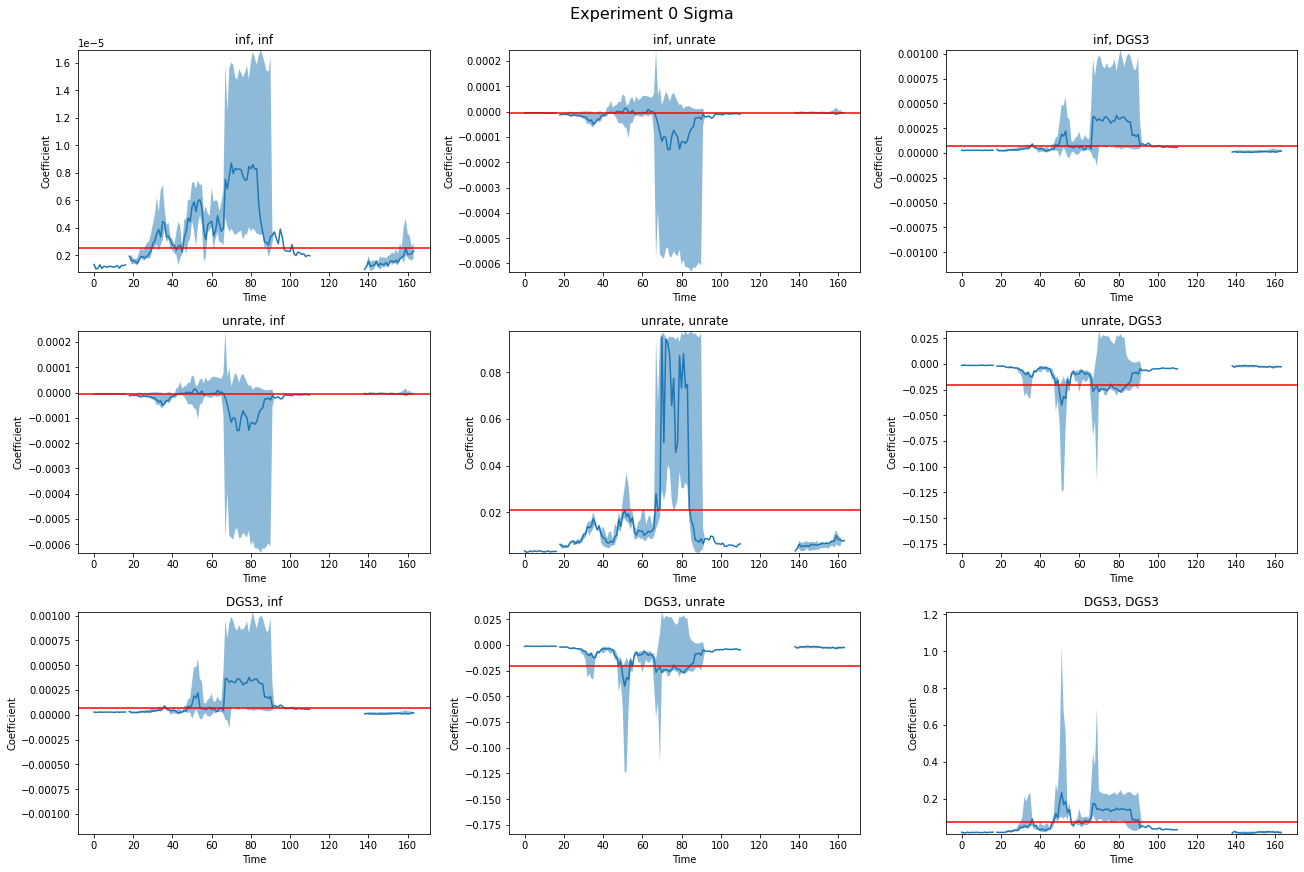

In [59]:
# Plot Covariance Matrix

# Don't show test (change this code to show in-sample)
if is_test == False:
  SIGMAS_ALL_PLOT = SIGMAS_ALL[:, :-test_size,:,:,:]
  cov_mat_tv_plot = cov_mat_tv[:-test_size, :, :] if is_simulation == True else None

  #SIGMAS_ALL_PLOT = SIGMAS_ALL[:, 9000:10000,:,:,:]
  #cov_mat_tv_plot = cov_mat_tv[9000:10000, :, :] if is_simulation == True else None
else:
  SIGMAS_ALL_PLOT = SIGMAS_ALL[:, -test_size:,:,:,:]
  cov_mat_tv_plot = cov_mat_tv[-test_size:, :, :] if is_simulation == True else None

for i in exps_to_plot:
  fig, axs = plt.subplots(n_vars, n_vars, figsize = (6 * n_vars, 4 * n_vars), constrained_layout = True)

  for row in range(n_vars):
    for col in range(n_vars):
      
      # Plot every bootstrap's value 
      if plot_all_bootstraps == True:
        for b in range(SIGMAS_IN_ALL.shape[4]):
          axs[row, col].plot(SIGMAS_ALL_PLOT[i, :, row, col, b], lw = 0.5, alpha = 0.15, label = i)

      axs[row, col].plot(np.nanmedian(SIGMAS_ALL_PLOT[i, :, row, col, :], axis = -1))
      axs[row, col].set_title(f'{var_names[row]}, {var_names[col]}')
      axs[row, col].set_xlabel('Time')
      axs[row, col].set_ylabel('Coefficient')

      sigmas_lcl = np.nanquantile(SIGMAS_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.16)
      sigmas_ucl = np.nanquantile(SIGMAS_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.84)
      axs[row, col].fill_between(list(range(SIGMAS_ALL_PLOT.shape[1])), sigmas_lcl, sigmas_ucl, alpha = 0.5)

      #Plot the actual covariance matrix values
      if is_simulation == True:
        axs[row, col].plot(cov_mat_tv_plot[:, row, col], color = 'black')

      # Set the y-axis limits to be at the min 10% LCL and max 10% UCL
      axs[row, col].set_ylim(
          np.nanmin(np.nanquantile(SIGMAS_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.1)),
          np.nanmax(np.nanquantile(SIGMAS_ALL_PLOT[i, :, row, col, :], axis = -1, q = 0.9))
      )
      # Plot the time-invariant covariance matrix
      axs[row, col].axhline(y = np.nanmedian(SIGMAS_CONS_ALL[i, row, col, :]), color = 'red', label = 'Time-Invariant')
  print('Time-Invariant Cov Mat', np.nanmedian(SIGMAS_CONS_ALL[i, :,:,:], axis = -1))
  print('Mean Median Time-varying Cov Mat', np.nanmean(np.nanmedian(SIGMAS_ALL_PLOT[i, :, :, :, :], axis = -1), axis = 0))

  fig.suptitle(f'Experiment {i} Sigma', fontsize=16)
  image_file = f'{image_folder_path}/{savefile_header}_sigmas_{i}{is_test_text}.png'
  plt.savefig(image_file, facecolor='w', transparent=False)

In [ ]:
# Simulations - Comparing MAEs of different experiments

maes = np.zeros((M_varnn, n_var))
for i in range(M_varnn):
  sigmas = np.nanmedian(SIGMAS_ALL_PLOT[i, :, :,:,:], axis = -1)
  mae = np.mean(np.abs(sigmas - cov_mat_tv_plot[i, :,:]), axis = 0)
  for var in range(n_var):
    maes[i, var] = mae[var, var]

maes_df = pd.DataFrame(maes)
maes_df['Average'] = np.mean(maes_df, axis = 1)
maes_df.sort_values('Average')

**Plotting Betas**

In [60]:
def plot_betas_all(BETAS, var_names, beta_names, image_file, q = 0.16, title = '', actual = None):

  BETAS = BETAS.copy()
  n_obs = BETAS.shape[0]
  n_betas = BETAS.shape[1]
  n_bootstraps = BETAS.shape[2]
  n_vars = BETAS.shape[3]
  print(n_vars, n_betas)
  fig, axs = plt.subplots(n_vars, n_betas, figsize = (6 * n_betas, 4 * n_vars), constrained_layout = True)

  for var in range(n_vars):
    for beta in range(n_betas):

      # Get the quantiles
      betas_lcl = np.nanquantile(BETAS[:, beta, :, var], q = q, axis = 1)
      betas_ucl = np.nanquantile(BETAS[:, beta, :, var], q = 1 - q, axis = 1)
      betas_median = np.nanmean(BETAS[:, beta, :, var], axis = 1)

      # betas_median = pd.Series(betas_median, index = dates)
      # betas_lcl = pd.Series(betas_lcl, index = dates)
      # betas_ucl = pd.Series(betas_ucl, index = dates)

      #Plot all bootstraps' paths
      if plot_all_bootstraps == True:
        for i in range(n_bootstraps):
          axs[var, beta].plot(BETAS[:, beta, i, var], lw = 0.5, alpha = 0.15)

      axs[var, beta].plot(betas_median, label = f'{var_names[var]} {beta_names[beta]}', lw = 1.5)
      # Plot the confidence bands
      axs[var, beta].fill_between(list(range(BETAS.shape[0])), betas_lcl, betas_ucl, alpha = 0.5)

      # Plot actual
      if actual is not None:
        actual_swapped = actual.copy()[:, :, [3,0,1,2]]
        axs[var, beta].plot(actual_swapped[:, var, beta], color = 'black')

      # Plot the confidence bands (old method, less preferred by PGC)
      # axs[var, beta].plot(betas_lcl, label = f'{var_names[var]} {beta_names[beta]}', lw = 1.5, color = 'black', ls = '--')
      # axs[var, beta].plot(betas_ucl, label = f'{var_names[var]} {beta_names[beta]}', lw = 1.5, color = 'black', ls = '--')

      # Vertical line for train/test split
      #axs[var, beta].axvline(results['oos_index'][0], color = 'black', linewidth = 1, linestyle = '--')
      # Horizontal line for OLS estimation
      #axs[var, beta].axhline(coefs_matrix[var, beta], color = 'green', linewidth = 1)

      #axs[var, beta].set_xticks(dates)

      #Set the y-axis limits to be at the min 10% LCL and max 10% UCL
      axs[var, beta].set_ylim(
          np.nanmin(np.nanquantile(BETAS[:, beta, :, var], axis = -1, q = 0.14)),
          np.nanmax(np.nanquantile(BETAS[:, beta, :, var], axis = -1, q = 0.86))
      )

      axs[var, beta].set_title(f'{var_names[var]}, {beta_names[beta]}')
      axs[var, beta].set_xlabel('Time')
      axs[var, beta].set_ylabel('Coefficient')

  fig.suptitle(title, fontsize=16)
  plt.savefig(image_file, facecolor='w', transparent=False)

In [ ]:
# @title Add the benchmark models in
# benchmark_folder_path = f'{folder_path}/benchmarks'
# benchmarks = ['VAR_expand', 'AR_expand', 'VAR_roll', 'AR_roll', 'VAR_whole', 'AR_whole']

# BETAS_BENCH = np.zeros((len(benchmarks), BETAS_ALL.shape[1], BETAS_ALL.shape[2], BETAS_ALL.shape[4]))
# BETAS_BENCH[:] = np.nan

# for i in range(len(benchmarks)):

#   # CHANGE BACK
#   out = np.load(f'{folder_path}/benchmarks/{savefile_header}benchmark_{benchmarks[i]}.npz')
  
#   betas_in_raw = out['betas_in']
  
#   betas_in_raw = np.transpose(betas_in_raw, (0,2,1))
#   betas_in_raw = betas_in_raw[:, beta_ids_to_keep, :]
#   print(betas_in_raw.shape)
#   BETAS_BENCH[i, :(betas_in_raw.shape[0]), :, :] = betas_in_raw

# all_names = experiments_names + benchmarks

3 4
3 4
3 4


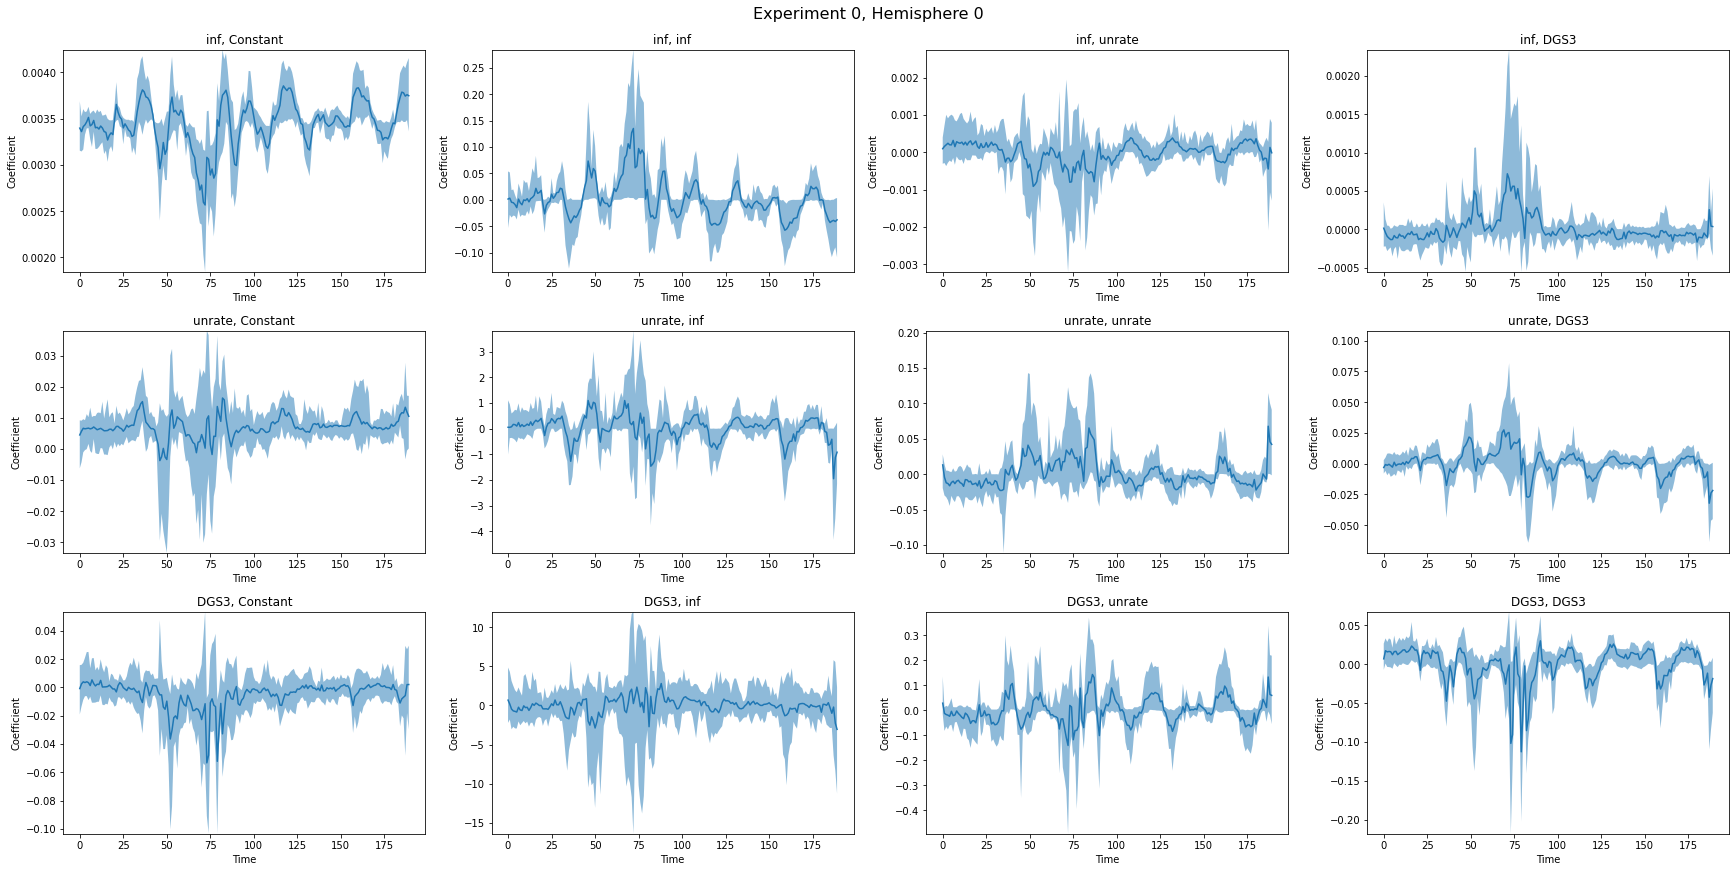

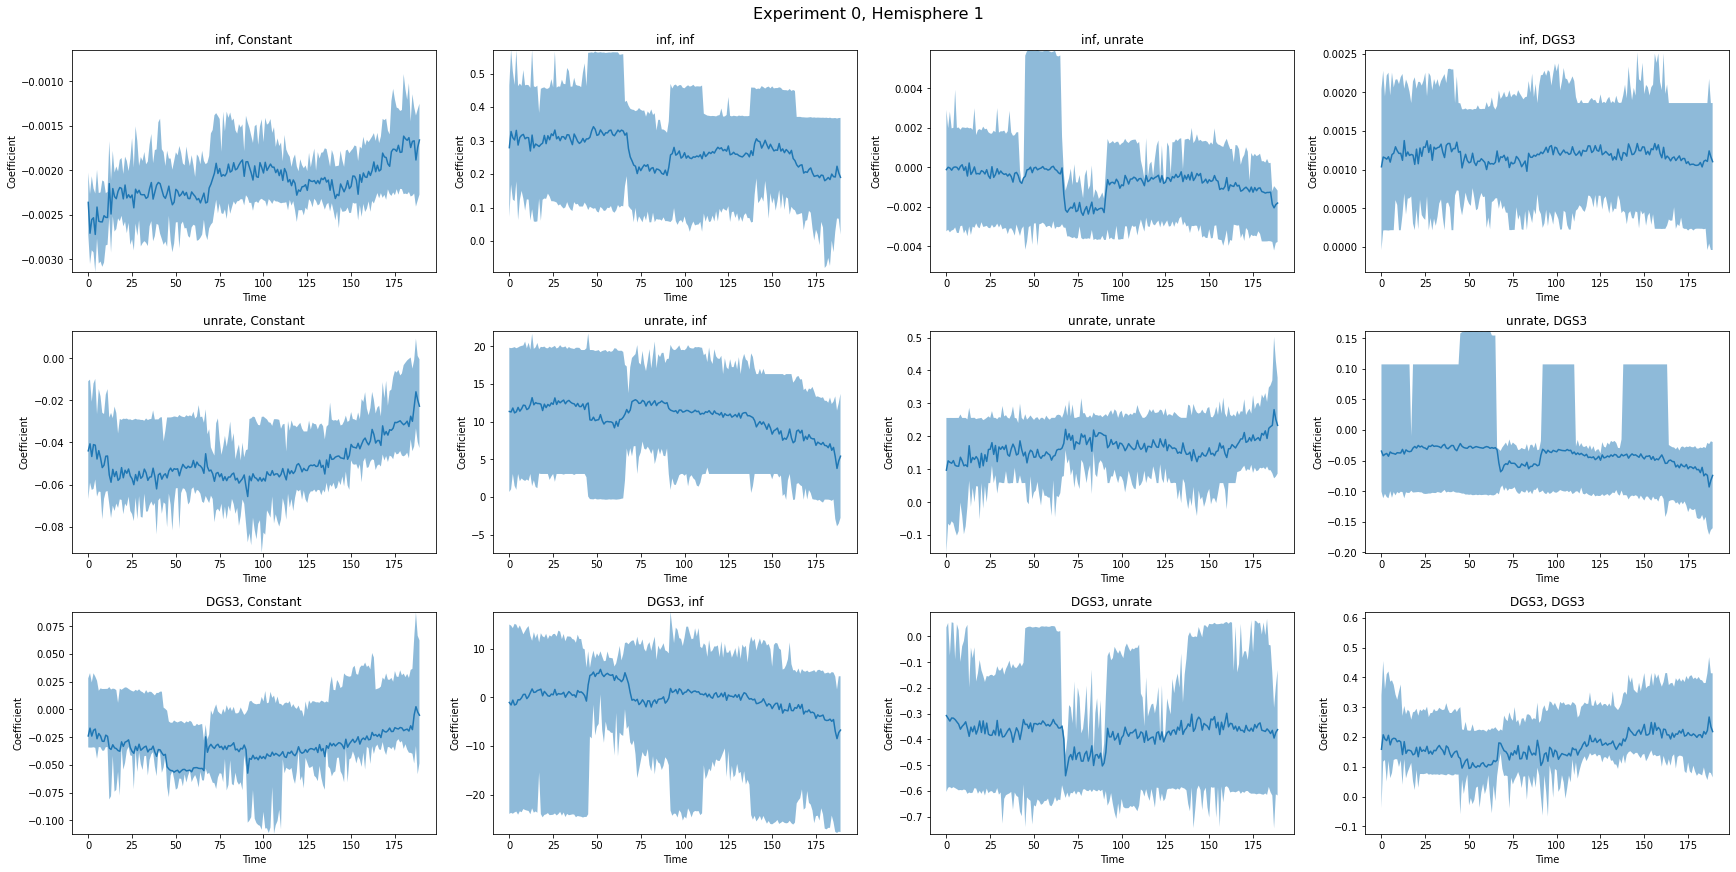

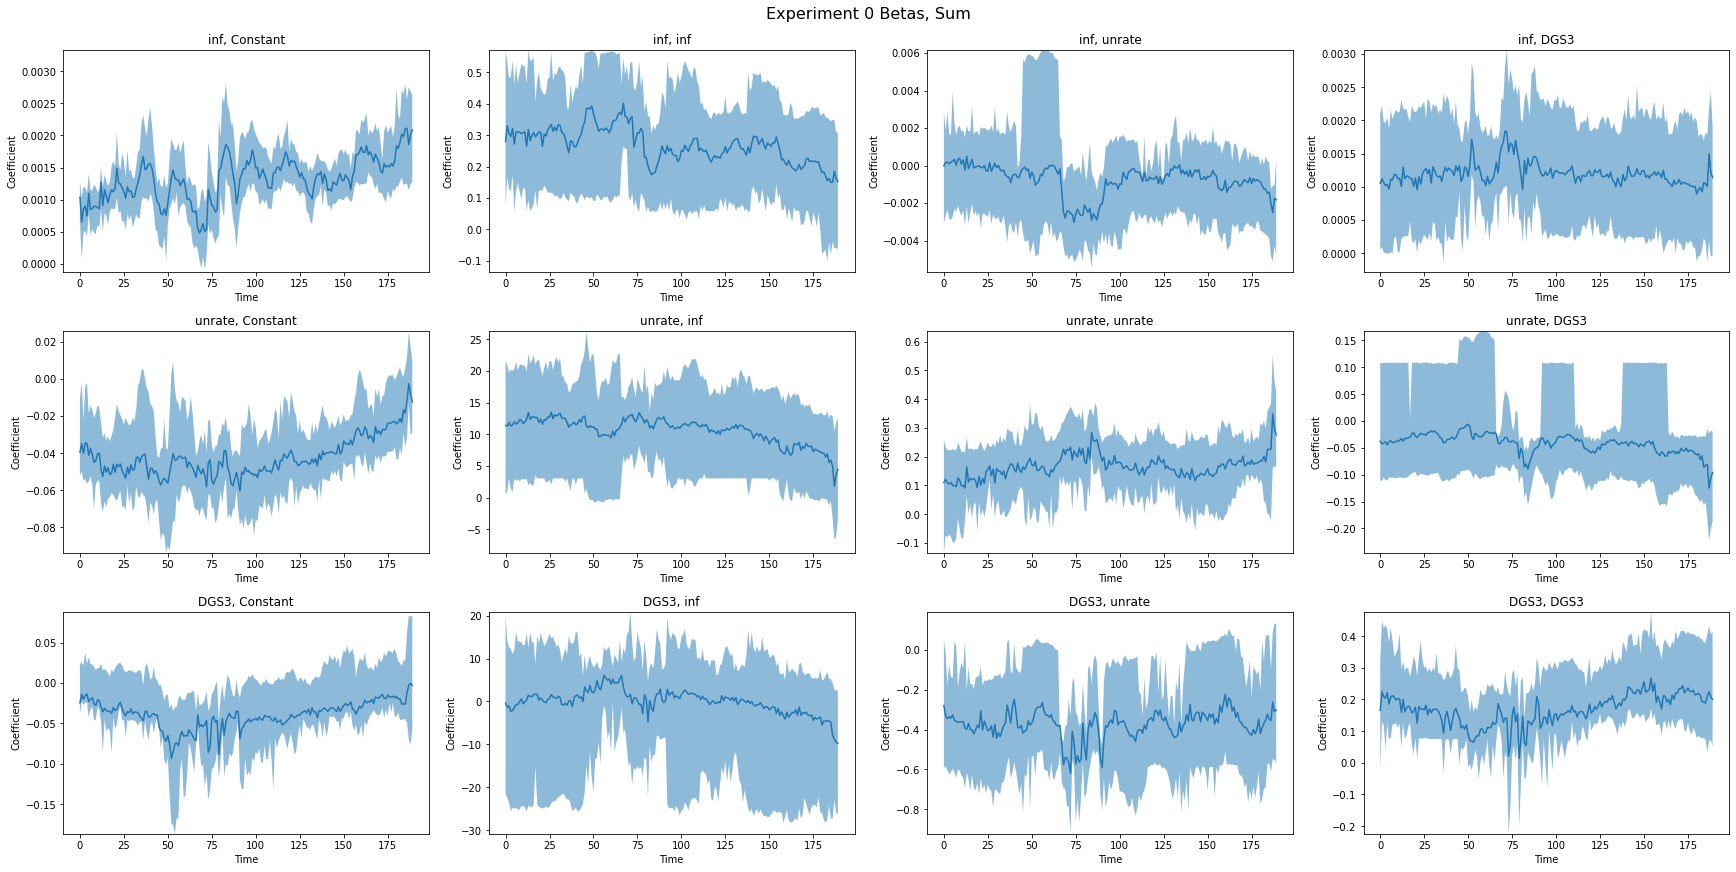

In [61]:
beta_names = ['Constant'] + var_names

# Plot individual hemisphere and summd betas
if is_test == False:
  BETAS_ALL_PLOT = BETAS_IN_ALL[:, :-test_size,:,:,:]
  coefs_tv_plot = coefs_tv[:-test_size, :, :] if is_simulation == True else None
  #BETAS_ALL_PLOT = BETAS_IN_ALL[:, 9000:10000,:,:,:]
 #coefs_tv_plot = coefs_tv[9000:10000, :, :] if is_simulation == True else None
else:
  BETAS_ALL_PLOT = BETAS_ALL[:, -test_size:,:,:,:]
  coefs_tv_plot = coefs_tv[-test_size:, :, :] if is_simulation == True else None

for i in exps_to_plot:
  for hemi in range(2):
#  for hemi in [0]:
    image_file = f'{image_folder_path}/betas_{i}_hemi_{hemi}{is_test_text}.png'
    plot_betas_all(BETAS_ALL_PLOT[i, :, :, :, :, hemi], var_names, beta_names, image_file, q = 0.16, title = f'Experiment {i}, Hemisphere {hemi}', actual = None)
  image_file = f'{image_folder_path}/dataset_{sim_dataset}_betas_{i}_sum{is_test_text}.png'
  plot_betas_all(np.sum(BETAS_ALL_PLOT[i, :, :, :, :,:], axis = -1), var_names, beta_names, image_file, q = 0.16, title = f'Experiment {i} Betas, Sum', actual = coefs_tv_plot)

**Simulations - Compare MAE**

In [ ]:
maes = np.zeros((M_varnn, n_var))
for i in range(M_varnn):
  betas = np.nanmedian(np.sum(BETAS_ALL_PLOT[i, :, :,:,:,:], axis = -1), axis = 2)
  betas = np.transpose(betas, (0, 2, 1))
  betas = betas[:, :, [1,2,3,0]]
  mae = np.mean(np.abs(betas - coefs_tv_plot), axis = 0)
  for var in range(n_var):
    maes[i, var] = mae[var, var]

In [ ]:
maes_df = pd.DataFrame(maes)
maes_df['Average'] = np.mean(maes_df, axis = 1)
maes_df.sort_values('Average')

In [ ]:
maes_df = pd.DataFrame(maes)
maes_df['Average'] = np.mean(maes_df, axis = 1)
maes_df.sort_values('Average')

**Compare TVPs aross different experiments**

In [ ]:
dates_all = pd.Series(pd.to_datetime(data.index[9:]))
recession_ids = [list(range(101, 122)) , list(range(155, 172)) , list(range(221, 232)) , list(range(245, 259)) , list(range(347, 364)) , list(range(482,490)), list(range(563, 583))]

In [ ]:
#dates_all = pd.Series(pd.to_datetime(data.index[-test_size:]))

In [ ]:
# title Plotting multiple experiments' TVPs in the same graph to compare - Within Same Folder (diff hyperparameters)
exp_names = ['Joint', 'Not Joint']
exps_to_compare = [0, 1]
n_betas = BETAS_ALL.shape[2]

if is_test == False:
  BETAS_ALL_PLOT = BETAS_ALL[:, :-test_size,:,:,:]
  dates = dates_all[:-test_size]
else:
  BETAS_ALL_PLOT = BETAS_ALL[:, -test_size:,:,:,:]
  dates = dates_all[-test_size:]

BETAS_ALL_PLOT_SUM = np.sum(BETAS_ALL_PLOT, axis = -1)

fig, axs = plt.subplots(n_vars, n_betas, figsize = (6 * n_betas, 4 * n_vars), constrained_layout = True)

for i in exps_to_compare:
  for var in range(n_vars):
    for beta in range(n_betas):
      betas_in_median = np.nanmedian(BETAS_ALL_PLOT_SUM[i, :, beta, :, var], axis = 1)
      betas_in_median = pd.DataFrame(betas_in_median, index = dates)
      axs[var, beta].plot(betas_in_median, label = exp_names[i], lw = 0.75)

      betas_in_lcl = np.nanquantile(BETAS_ALL_PLOT_SUM[i, :, beta, :, var], axis = 1, q = 0.16)
      betas_in_ucl = np.nanquantile(BETAS_ALL_PLOT_SUM[i, :, beta, :, var], axis = 1, q = 0.84)
      axs[var, beta].fill_between(dates, betas_in_lcl, betas_in_ucl, alpha = 0.5)

      # Fill in recessions
      # for recession in recession_ids:
      #   axs[var, beta].axvspan(dates.iloc[recession[0]], dates.iloc[recession[-1]], ymin = 0, ymax = 1, alpha = 0.25, color = 'pink')

      axs[var, beta].set_title(f'{var_names[var]}, {beta_names[beta]}')
      axs[var, beta].set_xlabel('Time')
      axs[var, beta].set_ylabel('Coefficient')
      
# # Plot benchmarks
# for b in range(len(benchmarks)):
#   for var in range(n_vars):
#     for beta in range(n_betas):
#       axs[var, beta].plot(BETAS_BENCH[b, :, beta, var], label = benchmarks[b], lw = 0.75)

      if var == 0 and beta == 0:
        axs[var, beta].legend()

plt.savefig(f'{image_folder_path}/6var_betas_compare.png')

### Other Plotting Code (not updated)

In [ ]:
# @title Plotting experiments of same model but over different train/test samples)
# Experiment Names: Test Sizes
experiments_names = [60, 90, 120, 150, 180, 240, 300]

n_vars = BETAS_IN_ALL.shape[4]
n_betas = BETAS_IN_ALL.shape[2]
fig, axs = plt.subplots(n_vars, n_betas, figsize = (6 * n_betas, 4 * n_vars), constrained_layout = True)

for i in range(M_varnn):
  for var in range(n_vars):
    for beta in range(n_betas):
      # Plot for the combined TVP (across all hemispheres) first
      #BETAS_THIS = np.sum(BETAS_IN_ALL_PLOT[i, :, beta, :, var, :], axis = -1)
      BETAS_THIS = np.sum(BETAS_ALL_PLOT[i, :, beta, :, var, :], axis = -1)
      # Time hemisphere
      #BETAS_THIS = BETAS_IN_ALL_PLOT[i, :, beta, :, var, 1]

      # Plot only the betas for the training data (i.e. cancel out the test data)
      BETAS_THIS[:(731-experiments_names[i]), :] = np.nan
      
      betas_in_median = np.nanmedian(BETAS_THIS, axis = 1)
      axs[var, beta].plot(betas_in_median, label = experiments_names[i], lw = 0.75)

      betas_in_lcl = np.nanquantile(BETAS_THIS, axis = 1, q = 0.16)
      betas_in_ucl = np.nanquantile(BETAS_THIS, axis = 1, q = 0.84)
      axs[var, beta].fill_between(list(range(betas_in_median.shape[0])), betas_in_lcl, betas_in_ucl, alpha = 0.5)

      axs[var, beta].set_title(f'{var_names[var]}, {beta_names[beta]}')
      axs[var, beta].set_xlabel('Time')
      axs[var, beta].set_ylabel('Coefficient')

      if var == 0 and beta == 0:
        axs[var, beta].legend()

plt.savefig(f'{image_folder_path}/betas_over_model_esttime_test.png')

In [ ]:
# @title Plotting multiple experiments' TVPs in the same graph to compare - Across different folders

beta_names = ['Constant'] + var_names
exp_names = ['3-year Yield', 'Shadow Rate']

n_vars = BETAS_IN_ALL.shape[4]
n_betas = BETAS_IN_ALL.shape[2]
fig, axs = plt.subplots(n_vars, n_betas, figsize = (6 * n_betas, 4 * n_vars), constrained_layout = True)

# Plot the VARNN
for i in [0, 1]:
  for var in range(n_vars):
    for beta in range(n_betas):
      betas_in_median = np.nanmedian(BETAS_IN_ALL_sum[i, :, beta, :, var], axis = 1)
      betas_in_median = pd.DataFrame(betas_in_median, index = dates)
      axs[var, beta].plot(betas_in_median, label = exp_names[i], lw = 0.75)

      betas_in_lcl = np.nanquantile(BETAS_IN_ALL_sum[i, :, beta, :, var], axis = 1, q = 0.16)
      betas_in_ucl = np.nanquantile(BETAS_IN_ALL_sum[i, :, beta, :, var], axis = 1, q = 0.84)
      axs[var, beta].fill_between(dates, betas_in_lcl, betas_in_ucl, alpha = 0.5)

      # Fill in recessions
      for recession in recession_ids:
        axs[var, beta].axvspan(dates.iloc[recession[0]], dates.iloc[recession[-1]], ymin = 0, ymax = 1, alpha = 0.25, color = 'pink')
#      axs[var, beta].fill_between(list(range(betas_in_median.shape[0])), betas_in_lcl, betas_in_ucl, alpha = 0.5)

      axs[var, beta].set_title(f'{var_names[var]}, {beta_names[beta]}')
      axs[var, beta].set_xlabel('Time')
      axs[var, beta].set_ylabel('Coefficient')
      
      if var == 3 and beta == 4:
        axs[var, beta].legend()

# # Plot benchmarks
# for b in range(len(benchmarks)):
#   for var in range(n_vars):
#     for beta in range(n_betas):
#       axs[var, beta].plot(BETAS_BENCH[b, :, beta, var], label = benchmarks[b], lw = 0.75)

#       if var == 3 and beta == 4:
#         axs[var, beta].legend()

plt.savefig(f'{image_folder_path}/betas_compare_1.png')

In [ ]:
# @title Plotting experiments of same model but over different number of variables
# Experiment Names: Test Sizes
experiments_names = [3,4,5,6,7]
test_size = 90

# Draw for one experiment ID
BETAS_ALL = BETAS_ALL_VARS[:,1,:,:,:,:,:]
BETAS_IN_ALL = BETAS_IN_ALL_VARS[:,1,:,:,:,:,:]

n_vars = BETAS_IN_ALL.shape[4]
n_betas = BETAS_IN_ALL.shape[2]
fig, axs = plt.subplots(n_vars, n_betas, figsize = (6 * n_betas, 4 * n_vars), constrained_layout = True)

for i in range(BETAS_IN_ALL.shape[0]):
  for var in range(n_vars):
    for beta in range(n_betas):
      # Plot for the combined TVP (across all hemispheres) first
      BETAS_THIS = np.sum(BETAS_IN_ALL[i, :, beta, :, var, :], axis = -1)
      #BETAS_THIS = np.sum(BETAS_ALL[i, :, beta, :, var, :], axis = -1)
      # Time hemisphere
      BETAS_THIS = BETAS_IN_ALL[i, :, beta, :, var, 1]

      # Plot only the betas for the training data (i.e. cancel out the test data)
      #BETAS_THIS[:(731-test_size), :] = np.nan
      
      betas_in_median = np.nanmedian(BETAS_THIS, axis = 1)
      axs[var, beta].plot(betas_in_median, label = experiments_names[i], lw = 0.75)

      betas_in_lcl = np.nanquantile(BETAS_THIS, axis = 1, q = 0.16)
      betas_in_ucl = np.nanquantile(BETAS_THIS, axis = 1, q = 0.84)
      axs[var, beta].fill_between(list(range(betas_in_median.shape[0])), betas_in_lcl, betas_in_ucl, alpha = 0.5)

      axs[var, beta].set_title(f'{var_names[var]}, {beta_names[beta]}')
      axs[var, beta].set_xlabel('Time')
      axs[var, beta].set_ylabel('Coefficient')

      if var == 0 and beta == 0:
        axs[var, beta].legend()

plt.savefig(f'{image_folder_path}/betas_over_diff_var_test_exp1_hemi1.png')

### Evaluating VSN Results

In [ ]:
V_ALL = np.zeros((892, 197, 2))
# Load all the betas from different experiments
for i in range(len(experiments_to_load)):
  experiment = experiments_to_load[i]

  out = np.load(f'{folder_path}/{savefile_header}params_{experiment}_repeat_0.npz', allow_pickle = True)

  experiments_names.append(out['params'].item()['name'])
  V_matrix = out['V_matrix']
  V_ALL[:,:,i] = np.nanmean(V_matrix, axis = 2)

In [ ]:
# Take mean across time to get the time-invariant variable importances
i = 1
time_inv_var_impt = np.mean(V_ALL[:, :, i], axis = 0)
var_impt_df = pd.DataFrame(time_inv_var_impt[0:32]).sort_values(by = 0, ascending = False)
display(var_impt_df.iloc[0:10])
print('Top 5 %: ' + str((var_impt_df.iloc[0:5].sum() / var_impt_df.sum() * 100)))

In [ ]:
# Take mean across time to get the time-invariant variable importances
i = 1
time_inv_var_impt = np.mean(V_ALL[:, :, i], axis = 0)
var_impt_df = pd.DataFrame(time_inv_var_impt[0:32]).sort_values(by = 0, ascending = False)
display(var_impt_df.iloc[0:10])
print('Top 5 %: ' + str((var_impt_df.iloc[0:5].sum() / var_impt_df.sum() * 100)))

## Evaluation of One-Step Forecasting


In [ ]:
# @title Load Betas from One Number of Variables

# Load Betas both from Experiment and Benchmarks

experiments_to_load = list(range(M_varnn))
experiments_names = []

M_betas = len(experiments_to_load)
M_benchmarks = 0
M_total = M_betas + M_benchmarks
M_with_hemi = []

# Load all the betas from different experiments
for i in range(len(experiments_to_load)):
  experiment = experiments_to_load[i]

  if need_to_combine == True:
    out = np.load(f'{folder_path}/{savefile_header}params_{experiment}_compiled.npz', allow_pickle = True)
  else:
    out = np.load(f'{folder_path}/{savefile_header}params_{experiment}_repeat_0.npz', allow_pickle = True)
  
  experiments_names.append(out['params'].item()['name'])
  BETAS = out['betas']
  BETAS_IN = out['betas_in']
  print('BETAS_IN', BETAS_IN.shape)

  # For experiments with more than 1 lag, get the ids of the 1st beta to plot
  beta_ids_to_keep = [0] + list(range(1, BETAS_IN.shape[1], n_lag_linear))
  print(beta_ids_to_keep)
  BETAS_IN = BETAS_IN[:, beta_ids_to_keep, :,:,:]
  BETAS = BETAS[:, beta_ids_to_keep, :,:,:]

  # Record the models that have >1 hemispheres
  if BETAS.shape[4] > 1:
    M_with_hemi.append(i)

  if i == 0:
    #BETAS_ALL = np.zeros((M_total, BETAS.shape[0], BETAS.shape[1], num_bootstraps, BETAS.shape[3], 2))
    BETAS_ALL = np.zeros((M_total, BETAS.shape[0], BETAS.shape[1], num_bootstraps, BETAS.shape[3], BETAS.shape[4]))
    BETAS_ALL[:] = np.nan
    # n_models x n_obs x n_betas x n_bootstraps x n_vars x n_hemispheres
    
    #BETAS_IN_ALL = np.zeros((M_total, BETAS_IN.shape[0], BETAS_IN.shape[1], num_bootstraps, BETAS_IN.shape[3], 2))
    BETAS_IN_ALL = np.zeros((M_total, BETAS_IN.shape[0], BETAS_IN.shape[1], num_bootstraps, BETAS_IN.shape[3], BETAS_IN.shape[4]))
    BETAS_IN_ALL[:] = np.nan 

  # If >1 hemis, Demean the time hemisphere and add the mean to the endogenous hemisphere
  # (note: the means are the in-sample means, not the oob ones)
  if BETAS.shape[4] > 1:
    time_hemi_means = np.nanmean(BETAS_IN[:,:,:,:,1], axis = 0)
    time_hemi_means_expand = np.repeat(np.expand_dims(time_hemi_means, axis = 0), BETAS.shape[0], axis = 0)
    # BETAS_IN[:, :, :, :, 0] = BETAS_IN[:, :, :, :, 0] + time_hemi_means_expand
    # BETAS_IN[:, :, :, :, 1] = BETAS_IN[:, :, :, :, 1] - time_hemi_means_expand
    # BETAS[:, :, :, :, 0] = BETAS[:, :, :, :, 0] + time_hemi_means_expand
    # BETAS[:, :, :, :, 1] = BETAS[:, :, :, :, 1] - time_hemi_means_expand

  BETAS_ALL[i,:,:,:BETAS_IN.shape[2],:, :BETAS_IN.shape[4]] = BETAS
  BETAS_IN_ALL[i,:,:,:BETAS_IN.shape[2],:, :BETAS_IN.shape[4]] = BETAS_IN

**Loading Forecasting Results from VARNN and Benchmarks**

In [ ]:
# @title Loading Results for Multiple Number of Variables (not in use)
# After this, PREDS_ALL_VARS has dimension (n_vars_tested, n_models, n_obs, n_bootstraps, n_vars_max))

# experiments_to_load = list(range(M_varnn))
# experiments_names = []

# M_betas = len(experiments_to_load)
# M_total = M_betas + M_benchmarks

# # Store the preds for the different variables
# PREDS_TEST_ALL_list = []
# PREDS_ALL_list = []

# for n_var in [3,4,5,6,7]:
#   # Load all the betas from different experiments
#   for i in range(len(experiments_to_load)):
#     experiment = experiments_to_load[i]
#     savefile_header = f'{n_var}var_'
#     out = np.load(f'{folder_path}/{savefile_header}params_{experiment}_compiled.npz', allow_pickle = True)

#     if n_var == 3:
#       experiments_names.append(out['params'].item()['name'])
#     #experiments_names.append(f'Exp {i}')
#     preds = out['train_preds']
#     preds_test = out['test_preds']
#     y_train = out['y']
#     y_test = out['y_test']
#     print(i, y_train.shape, y_test.shape, preds.shape, preds_test.shape)

#     if i == 0:
#       PREDS_ALL = np.zeros((M_total, preds.shape[0], num_bootstraps, preds.shape[2]))
#       PREDS_ALL[:] = np.nan
#       PREDS_TEST_ALL = np.zeros((M_total, preds_test.shape[0], num_bootstraps, preds_test.shape[2]))
#       PREDS_TEST_ALL[:] = np.nan 
#       PREDS_ALL[0,:,:preds_test.shape[1],:] = preds
#       PREDS_TEST_ALL[0,:,:preds_test.shape[1],:] = preds_test
#     else:
#       PREDS_ALL[i,:,:preds_test.shape[1],:] = preds
#       PREDS_TEST_ALL[i,:,:preds_test.shape[1],:] = preds_test

#   # Add the benchmark models in
#   benchmark_folder_path = f'{folder_path}/benchmarks'

#   for i in range(M_benchmarks):

#     out = np.load(f'{benchmark_folder_path}/{savefile_header}benchmark_{benchmarks[i]}.npz')

#     preds = out['train_preds']
#     preds_test = out['test_preds']
#     Y_train = out['y']
#     Y_test = out['y_test']
#     print(i, y_train.shape, y_test.shape, preds.shape, preds_test.shape)

#     preds = np.repeat(np.expand_dims(preds, axis = 1), num_bootstraps, axis = 1)
#     preds_test = np.repeat(np.expand_dims(preds_test, axis = 1), num_bootstraps, axis = 1)
#     PREDS_ALL[M_betas + i, :,:,:] = preds
#     PREDS_TEST_ALL[M_betas + i,:,:,:] = preds_test

#   # Reshape the preds to make the variables fit in the corresponding places
#   PREDS_ALL_reshaped = np.zeros((PREDS_ALL.shape[0], PREDS_ALL.shape[1], PREDS_ALL.shape[2], 7))
#   PREDS_ALL_reshaped[:] = np.nan
#   PREDS_TEST_ALL_reshaped = np.zeros((PREDS_TEST_ALL.shape[0], PREDS_TEST_ALL.shape[1], PREDS_TEST_ALL.shape[2], 7))
#   PREDS_TEST_ALL_reshaped[:] = np.nan

#   var_locations = {3: [3,4,5],
#                    4: [0,3,4,5],
#                    5: [0,2,3,4,5],
#                    6: [0,1,2,3,4,5],
#                    7: [0,1,2,3,4,5,6]}

#   PREDS_ALL_reshaped[:, :, :, var_locations[n_var]] = PREDS_ALL
#   PREDS_TEST_ALL_reshaped[:, :, :, var_locations[n_var]] = PREDS_TEST_ALL

#   PREDS_TEST_ALL_list.append(PREDS_TEST_ALL_reshaped)
#   PREDS_ALL_list.append(PREDS_ALL_reshaped)

# # Stack all together
# PREDS_TEST_ALL_VARS = np.stack(PREDS_TEST_ALL_list)
# PREDS_ALL_VARS = np.stack(PREDS_ALL_list)

# all_names = experiments_names + benchmarks
# test_size = Y_test.shape[0]

In [ ]:
# @title Loading Results for Experiments with One Number of Variables

experiments_to_load = list(range(M_varnn))
experiments_names = []

M_betas = len(experiments_to_load)
M_total = M_betas + M_benchmarks

# Load all the betas from different experiments
for i in range(len(experiments_to_load)):
  experiment = experiments_to_load[i]
  
  if need_to_combine == True:
    out = np.load(f'{folder_path}/{savefile_header}params_{experiment}_compiled.npz', allow_pickle = True)
  else:
    out = np.load(f'{folder_path}/{savefile_header}params_{experiment}_repeat_0.npz', allow_pickle = True)
  
  experiments_names.append(out['params'].item()['name'])
  preds = out['train_preds']
  preds_test = out['test_preds']
  y_train = out['y']
  y_test = out['y_test']
  print(i, y_train.shape, y_test.shape, preds.shape, preds_test.shape)

  if i == 0:
    PREDS_ALL = np.zeros((M_total, preds.shape[0], num_bootstraps, preds.shape[2]))
    PREDS_ALL[:] = np.nan
    PREDS_TEST_ALL = np.zeros((M_total, preds_test.shape[0], num_bootstraps, preds_test.shape[2]))
    PREDS_TEST_ALL[:] = np.nan 
    PREDS_ALL[0,:,:preds_test.shape[1],:] = preds
    PREDS_TEST_ALL[0,:,:preds_test.shape[1],:] = preds_test
  else:
    PREDS_ALL[i,:,:preds_test.shape[1],:] = preds
    PREDS_TEST_ALL[i,:,:preds_test.shape[1],:] = preds_test

# Add the benchmark models in
if M_benchmarks > 0:
  benchmark_folder_path = f'{folder_path}/benchmarks'

  for i in range(M_benchmarks):

    out = np.load(f'{benchmark_folder_path}/{savefile_header}benchmark_{benchmarks[i]}.npz')

    preds = out['train_preds']
    preds_test = out['test_preds']
    Y_train = out['y']
    Y_test = out['y_test']
    print(i, y_train.shape, y_test.shape, preds.shape, preds_test.shape)

    preds = np.repeat(np.expand_dims(preds, axis = 1), num_bootstraps, axis = 1)
    preds_test = np.repeat(np.expand_dims(preds_test, axis = 1), num_bootstraps, axis = 1)
    PREDS_ALL[M_betas + i, :,:,:] = preds
    PREDS_TEST_ALL[M_betas + i,:,:,:] = preds_test

  all_names = experiments_names + benchmarks
else:
  all_names = experiments_names

In [ ]:
# 1: Plot predictions
n_var = PREDS_ALL.shape[3]

fig, ax = plt.subplots(n_var, 1, figsize = (12, 3 * n_var), constrained_layout = True)

for i in range(M_total):

  preds_median = np.nanmedian(PREDS_ALL[i,:,:,:], axis = 1)
  preds_test_median = np.nanmedian(PREDS_TEST_ALL[i,:,:,:], axis = 1)
  for var in range(n_var):
    if i < M_betas:
      ax[var].plot(preds_median[:, var], lw = 0.75, label = all_names[i])
    if i == len(experiments_to_load) - 1:
      ax[var].plot(y_train[:, var], lw = 1, label = 'Actual', color = 'black')
      ax[var].set_title(var_names[var])
    if i >= M_betas:
      ax[var].plot(preds_median[:, var], lw = 0.75, label = all_names[i], ls = 'dotted')

    if var == 0:
      ax[var].legend()

plt.savefig(f'{image_folder_path}/preds.png')

In [ ]:
# @title OOB Errors for Diff Number of Variables (not in use)

# # 1a: Plotting the OOB prediction errors for different number of variables

# fig, ax = plt.subplots(1,n_var, figsize = (6 * n_var, 6), constrained_layout = True)

# for n_vars_id in range(PREDS_ALL_VARS.shape[0]-1, -1, -1):
#   PREDS_ALL = PREDS_ALL_VARS[n_vars_id,:,:,:,:]
#   PREDS_TEST_ALL = PREDS_TEST_ALL_VARS[n_vars_id,:,:,:,:]

#   # Calculating errors
#   preds_median = np.nanmedian(PREDS_ALL, axis = 2)
#   preds_test_median = np.nanmedian(PREDS_TEST_ALL, axis = 2)
#   y_train_repeated = np.repeat(np.expand_dims(y_train, axis = 0), M_total, axis = 0)
#   errors = np.abs(preds_median - y_train_repeated)
#   cum_errors = np.cumsum(errors, axis = 1)

#   # Baseline: 7-variable model
#   if n_vars_id == PREDS_ALL_VARS.shape[0]-1:
#     benchmark_cum_error = cum_errors[0, :, :]

#   # Only draw the benchmark model
#   for i in [0]:
    
#     for var in range(n_var):
#       if i == 0:
#         ax[var].set_title(var_names[var])
#       if i >= M_betas: # Make benchmarks dotted
#         ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var], label = n_vars_id + 3, ls = 'dotted')
#       else:
#         ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var] , label = n_vars_id + 3)

#       if var == 0:
#         ax[var].legend()

# plt.savefig(f'{image_folder_path}/cum_errors_diff_vars_benchmark.png')

In [ ]:
# 2: Plotting the prediction errors for different models, as well as cumulative errors - OOB

# if there are multiple numbers of variables
# n_vars_id = 3
# PREDS_ALL = PREDS_ALL_VARS[n_vars_id,:,:,:,:]
# PREDS_TEST_ALL = PREDS_TEST_ALL_VARS[n_vars_id,:,:,:,:]

fig, ax = plt.subplots(1,n_var, figsize = (6 * n_var, 4), constrained_layout = True)

for i in range(M_total):

  preds_median = np.nanmedian(PREDS_ALL[i,:,:,:], axis = 1)
  preds_test_median = np.nanmedian(PREDS_TEST_ALL[i,:,:,:], axis = 1)
  error = np.abs(y_train - preds_median)

  cum_error = np.nancumsum(error, axis = 0)

  for var in range(n_var):
    if i == 0:
      ax[var].set_title(var_names[var])
    ax[var].plot(error[:, var], lw = 0.5, label = all_names[i])
    if var == 0:
      ax[var].legend()

plt.savefig(f'{image_folder_path}/error.png')

fig, ax = plt.subplots(1,n_var, figsize = (6 * n_var, 4), constrained_layout = True)

# Calculating errors
preds_median = np.nanmedian(PREDS_ALL, axis = 2)
preds_test_median = np.nanmedian(PREDS_TEST_ALL, axis = 2)
y_train_repeated = np.repeat(np.expand_dims(y_train, axis = 0), M_total, axis = 0)
errors = np.abs(preds_median - y_train_repeated)
cum_errors = np.nancumsum(errors, axis = 1)

# Choose the benchmark (to change!)
benchmark_cum_error = cum_errors[(M_varnn - 5), :, :]

for i in range(M_total):
  
  for var in range(n_var):
    if i == 0:
      ax[var].set_title(var_names[var])
    if i >= M_betas: # Make benchmarks dotted
      ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var], label = all_names[i], ls = 'dotted')
    else:
      ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var], label = all_names[i])

    if var == 0:
      ax[var].legend()

plt.savefig(f'{image_folder_path}/6var_cum_errors.png')

In [ ]:
# 3: Compare the OOB MAE across VARNN and Benchmark Models 

cum_errors_dict = {}
for i, exp_name in enumerate(all_names):
  cum_errors_dict.update({exp_name: cum_errors[i, -1, :]})

cum_errors_df = pd.DataFrame(cum_errors_dict)

# Best Benchmark
cum_errors_df['Best Benchmark'] = cum_errors_df.iloc[:, -7:].min(axis = 1)

# Get errors relative to best benchmark
cum_errors_df = cum_errors_df.div(cum_errors_df['Best Benchmark'], axis = 0)

# Get Best VARNN model
cum_errors_df['Best VARNN'] = cum_errors_df.iloc[:, :-8].min(axis = 1)
cum_errors_df = cum_errors_df.T
cum_errors_df.columns = var_names
cum_errors_df

In [ ]:
a = cum_errors_df['inf'].copy()

In [ ]:
# @title Test Errors for Diff Number of Variables

# 3a: Plotting the OOB prediction errors for different number of variables

fig, ax = plt.subplots(1,n_var, figsize = (6 * n_var, 6), constrained_layout = True)

for n_vars_id in range(PREDS_ALL_VARS.shape[0]-1, -1, -1):
  PREDS_ALL = PREDS_ALL_VARS[n_vars_id,:,:,:,:]
  PREDS_TEST_ALL = PREDS_TEST_ALL_VARS[n_vars_id,:,:,:,:]

  # Calculating errors
  preds_median = np.nanmedian(PREDS_ALL, axis = 2)
  preds_test_median = np.nanmedian(PREDS_TEST_ALL, axis = 2)
  y_train_repeated = np.repeat(np.expand_dims(y_train, axis = 0), M_total, axis = 0)
  errors = np.abs(preds_median - y_train_repeated)
  cum_errors = np.cumsum(errors, axis = 1)
  # Remove COVID
  cum_errors = cum_errors[:, :(test_size - 20), :]

  # Baseline: 7-variable model
  if n_vars_id == PREDS_ALL_VARS.shape[0]-1:
    benchmark_cum_error = cum_errors[0, :, :]

  # Only draw the benchmark model
  for i in [0]:
    
    for var in range(n_var):
      if i == 0:
        ax[var].set_title(var_names[var])
      if i >= M_betas: # Make benchmarks dotted
        ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var], label = n_vars_id + 3, ls = 'dotted')
      else:
        ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var] , label = n_vars_id + 3)

      if var == 0:
        ax[var].legend()

plt.savefig(f'{image_folder_path}/test_cum_errors_diff_vars_benchmark.png')

In [ ]:
# 4: Plotting the prediction errors for different models, as well as cumulative errors - Test Set

# n_vars_id = 0
# PREDS_ALL = PREDS_ALL_VARS[n_vars_id,:,:,:,:]
# PREDS_TEST_ALL = PREDS_TEST_ALL_VARS[n_vars_id,:,:,:,:]

fig, ax = plt.subplots(1,n_var, figsize = (6 * n_var, 4), constrained_layout = True)


for i in range(M_total):

  preds_median = np.nanmedian(PREDS_ALL[i,:,:,:], axis = 1)
  preds_test_median = np.nanmedian(PREDS_TEST_ALL[i,:,:,:], axis = 1)

  for var in range(n_var):
    if i == 0:
      ax[var].set_title(var_names[var])
      ax[var].plot(y_test[:, var], lw = 2.5, label = 'Actual', c = 'black')
    # elif i == M_betas - 1: # Make Vanilla NN benchmark
    #   ax[var].plot(preds_test_median[:-20, var], label = all_names[i], c = 'brown', lw = 2.5)
    
    ax[var].plot(preds_test_median[:, var], lw = 1, label = all_names[i])
    if var == 0:
      ax[var].legend()

plt.savefig(f'{image_folder_path}/test_preds.png')

fig, ax = plt.subplots(1,n_var, figsize = (8 * n_var, 6), constrained_layout = True)

# Calculating errors
preds_test_median = np.nanmedian(PREDS_TEST_ALL, axis = 2)
y_test_repeated = np.repeat(np.expand_dims(y_test, axis = 0), M_total, axis = 0)
errors = np.abs(preds_test_median - y_test_repeated)
cum_errors = np.nancumsum(errors, axis = 1)

# Remove COVID
cum_errors = cum_errors[:, :(test_size), :]
benchmark_cum_error = cum_errors[(M_varnn - 5), :, :]

for i in range(M_total):
  
  for var in range(n_var):
    if i == 0:
      ax[var].set_title(var_names[var])

    if i >= M_betas: # Make benchmarks dotted
      ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var], label = all_names[i], ls = 'dotted')
    # elif i == M_betas - 1: # Make Vanilla NN benchmark
    #   ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var], label = all_names[i], c = 'brown', lw = 2.5)
    else:
      ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var], label = all_names[i])
    #ax[var].plot(cum_errors[i, :, var], label = experiments_names[i])
    if var == 0:
      ax[var].legend()

plt.savefig(f'{image_folder_path}/6var_test_cum_errors_covid.png')

In [ ]:
# 5: Compare the Test MAE 

cum_errors_dict = {}
for i, exp_name in enumerate(all_names):
  cum_errors_dict.update({exp_name: cum_errors[i, -1, :]})

cum_errors_df = pd.DataFrame(cum_errors_dict)

# Best Benchmark
cum_errors_df['Best Benchmark'] = cum_errors_df.iloc[:, (-M_benchmarks):].min(axis = 1)

# Get Best VARNN model
cum_errors_df['Best VARNN'] = cum_errors_df.iloc[:, :-(M_benchmarks+2)].min(axis = 1)
cum_errors_df = cum_errors_df.T
cum_errors_df.columns = var_names
cum_errors_df

In [ ]:
# 5: Compare the Test MAE across VARNN and Benchmark Models 

cum_errors_dict = {}
for i, exp_name in enumerate(all_names):
  cum_errors_dict.update({exp_name: cum_errors[i, -1, :]})

cum_errors_df = pd.DataFrame(cum_errors_dict)

# Best Benchmark
cum_errors_df['Best Benchmark'] = cum_errors_df.iloc[:, (-M_benchmarks):].min(axis = 1)

# Get errors relative to VAR(whole)
cum_errors_df = cum_errors_df.div(cum_errors_df['VAR_roll'], axis = 0)

# Get Best VARNN model
cum_errors_df['Best VARNN'] = cum_errors_df.iloc[:, :-(M_benchmarks+2)].min(axis = 1)
cum_errors_df = cum_errors_df.T
cum_errors_df.columns = var_names
cum_errors_df

## Evaluating Multi-Horizon Forecasting

In [ ]:
# All the manual entries to fill up before running the results

experiment_name = '6jul_multi_forecasting'
n_vars = 3
n_lag_linear = 2
M_varnn = 1 # Number of VARNN models
need_to_combine = False

savefile_header = ''

M_benchmarks = 6
benchmarks = ['expanding_var', 'rolling_var', 'expanding_ar', 'rolling_ar', 'XGBoost', 'RF']
benchmarks = benchmarks[:M_benchmarks]
num_bootstraps = 50
test_size = 60

var_names = ['Inf', 'Unrate', 'DGS3']

In [ ]:
# Parameters
h = 6 # Number of horizons to forecast
B = 50 # Number of simulation bootstraps
T = 60 # Size of test set
n_var = 3
reestimation_window = 60 # Size of window after which you re-estimate the model
R = int(T / reestimation_window)

n_lag_d = 8
n_lag_linear = 2
n_lag_ps = 2

Y_test = np.array(x_d)[-(T+20):-20, :]

In [ ]:
folder_path = f'New Experiments/{experiment_name}'

# Create image folder if not exist yet
image_folder_path = f'{folder_path}/images'
if os.path.isdir(image_folder_path) == False:
  os.mkdir(image_folder_path)

In [ ]:
# @title Loading Results for Experiments with One Number of Variables
experiments_names = []

M_total = M_varnn + M_benchmarks
# M_total x horizon x variable x bootstraps x test x re-estimation window
Y_pred_big = np.zeros((M_total, h+1, n_var, T, R))

# Load all the betas from different experiments
for i in range(M_varnn):

  with open(f'{folder_path}/params_{i}_forecasting_repeat_0.npz', 'rb') as f:
    FCAST = np.load(f)

  # with open(f'{folder_path}/rf_forecast.npz', 'rb') as f:
  #   FCAST = np.load(f)
  experiments_names.append(f'Exp {i}')
  FCAST_nan = FCAST.copy()
  FCAST_nan[FCAST_nan == 0] = np.nan
  Y_pred = np.nanmedian(FCAST_nan, axis = 2)
  Y_pred_big[i, :,:,:,:] = Y_pred

# Add the benchmark models in
if M_benchmarks > 0:
  benchmark_folder_path = f'{folder_path}'

for benchmark_id in range(M_benchmarks):
  FCAST = np.load(f'{benchmark_folder_path}/{benchmarks[benchmark_id]}_forecasting.npz')
  FCAST_nan = FCAST.copy()
  FCAST_nan[FCAST_nan == 0] = np.nan
  if benchmarks[benchmark_id] in ['XGBoost', 'RF']:
    Y_pred = np.nanmedian(FCAST_nan, axis = 2)
    Y_pred_big[M_varnn + benchmark_id, :,:,:,:] = Y_pred
  else:
    Y_pred_big[M_varnn + benchmark_id, :,:,:,:] = FCAST_nan[:, :, :, 0:1]

  experiments_names.append(benchmarks[benchmark_id])


In [ ]:
# Investigating different re-estimation models (for a given horizon)
# *Remove COVID

fig, ax = plt.subplots(1,n_var, figsize = (n_var * 6, 4), constrained_layout = True)

for var in range(n_var):
  ax[var].plot(Y_test[:-20, var], label = 'Actual')
  ax[var].set_title(var_names[var])

horizon = 1

for r in range(R):
  Y_pred_r = np.transpose(Y_pred[horizon, :, :, r]).copy()
  Y_pred_r[horizon:, :] = Y_pred_r[:(T-horizon), :]
  Y_pred_r[:horizon, :] = np.nan
  for var in range(n_var):
    ax[var].plot(Y_pred_r[:-20, var], label = f'r = {r}')

if var == (n_var - 1):
  ax[var].legend()

In [ ]:
# Get the prediction from the latest model only (ffill)

Y_pred_latest = Y_pred.copy()
for horizon in range(1, h + 1):
  for var in range(n_var):
    a = Y_pred_latest[horizon, var, :, :]
    mask = np.isnan(a)
    # where there is a value, fill with the idx, if Na then fill 0
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    # Get the cumulative maximum of of the idx along the axis
    np.maximum.accumulate(idx, axis = 1, out = idx)
    # Replace the nan values with the value at cum max idx with value
    a[mask] = a[np.nonzero(mask)[0], idx[mask]]

Y_pred_latest = Y_pred_latest[:, :, :, -1]

In [ ]:
Y_pred_big_latest = Y_pred_big[:, :, :, :, -1]

In [ ]:
# Investigating different horizons

for horizon in range(1, h+1):
  fig, ax = plt.subplots(1,n_var, figsize = (n_var * 6, 4), constrained_layout = True)

  # Plot actual
  for var in range(n_var):
    ax[var].set_title(f'{var_names[var]}, h = {horizon}')
    ax[var].plot(Y_test[:70, var], label = 'Actual', color = 'black')
  
  # Plot predicted
  for model in range(Y_pred_big_latest.shape[0]):

    Y_pred_h = np.transpose(Y_pred_big_latest[model, horizon, :, :]).copy()
    # Shift forward by horizon
    Y_pred_h[horizon:, :] = Y_pred_h[:(T-horizon), :]
    Y_pred_h[:horizon, :] = np.nan

    for var in range(n_var):
      ax[var].plot(Y_pred_h[:, var], label = experiments_names[model])
  if var == (n_var - 1):
    ax[var].legend()

In [ ]:
for horizon in range(1, h+1):
#for horizon in [1]:
  fig, ax = plt.subplots(1,n_var, figsize = (n_var * 6, 4), constrained_layout = True)

  cum_error_benchmark = np.zeros((60, n_var))
  cum_error_benchmark[:] = np.nan

  # Plot actual
  for var in range(n_var):
    ax[var].set_title(f'{var_names[var]}, h = {horizon}')
    
  
  # Plot predicted
  for model in range(Y_pred_big_latest.shape[0]):
#  for model in [3]:
    Y_pred_h = np.transpose(Y_pred_big_latest[model, horizon, :, :]).copy()
    # Shift forward by horizon
    Y_pred_h[horizon:, :] = Y_pred_h[:(T-horizon), :]
    Y_pred_h[:horizon, :] = np.nan

    for var in range(n_var):
      actual = Y_test[:, var]
      pred = Y_pred_h[:, var]
      error = np.abs(actual - pred)
      cum_error = np.nancumsum(error)
      
      if model == 0:
        cum_error_benchmark[:,var] = cum_error.copy()
      
      ax[var].plot(cum_error - cum_error_benchmark[:,var], label = experiments_names[model])
#      ax[var].plot(cum_error, label = experiments_names[model])

  if var == (n_var - 1):
    ax[var].legend()

In [ ]:
# Calculating MSEs 

fig, ax = plt.subplots(1,n_var, figsize = (6 * n_var, 4), constrained_layout = True)


for i in range(M_total):

  preds_median = np.nanmedian(PREDS_ALL[i,:,:,:], axis = 1)
  preds_test_median = np.nanmedian(PREDS_TEST_ALL[i,:,:,:], axis = 1)

  for var in range(n_var):
    if i == 0:
      ax[var].set_title(var_names[var])
      ax[var].plot(y_test[:, var], lw = 2.5, label = 'Actual', c = 'black')
    # elif i == M_betas - 1: # Make Vanilla NN benchmark
    #   ax[var].plot(preds_test_median[:-20, var], label = all_names[i], c = 'brown', lw = 2.5)
    
    ax[var].plot(preds_test_median[:, var], lw = 1, label = all_names[i])
    if var == 0:
      ax[var].legend()

plt.savefig(f'{image_folder_path}/test_preds.png')

fig, ax = plt.subplots(1,n_var, figsize = (8 * n_var, 6), constrained_layout = True)

# Calculating errors
preds_test_median = np.nanmedian(PREDS_TEST_ALL, axis = 2)
y_test_repeated = np.repeat(np.expand_dims(y_test, axis = 0), M_total, axis = 0)
errors = np.abs(preds_test_median - y_test_repeated)
cum_errors = np.nancumsum(errors, axis = 1)

# Remove COVID
cum_errors = cum_errors[:, :(test_size), :]
benchmark_cum_error = cum_errors[(M_varnn - 5), :, :]

for i in range(M_total):
  
  for var in range(n_var):
    if i == 0:
      ax[var].set_title(var_names[var])

    if i >= M_betas: # Make benchmarks dotted
      ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var], label = all_names[i], ls = 'dotted')
    # elif i == M_betas - 1: # Make Vanilla NN benchmark
    #   ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var], label = all_names[i], c = 'brown', lw = 2.5)
    else:
      ax[var].plot(cum_errors[i, :, var] - benchmark_cum_error[:, var], label = all_names[i])
    #ax[var].plot(cum_errors[i, :, var], label = experiments_names[i])
    if var == 0:
      ax[var].legend()

plt.savefig(f'{image_folder_path}/6var_test_cum_errors_covid.png')